In [ ]:
!pip install GPyOpt
!pip install GPy

In [2]:
#import packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt
import GPy
import GPyOpt
import seaborn as sns

In [3]:
#reading csv file for Boston Housing Dataset
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['hou_all.csv']),\
                 names = ['CRIM','ZN','INDUS','CHAS','NOS','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df.head()

Saving hou_all.csv to hou_all.csv


,CRIM,ZN,INDUS,CHAS,NOS,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
#parameters = CRIM , ZN, INDUS
X = df.iloc[:,0:3].to_numpy()

#target = MEDV
Y = df.iloc[:,-1].to_numpy()

#train test split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.3, random_state = 10)

SVM = SVR()
SVM.fit(xTrain,yTrain)
yPred = SVM.predict(xTest)
print(SVM.get_params())

{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [5]:
#array of different params, score
list_C=[]
list_gamma=[]
list_score=[]

#search domain
bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 0.1)}
      ]

#black-box function
def SVM_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  reg = SVR(C=params['C'],gamma=params['gamma'])
  reg.fit(xTrain,yTrain)
  yPred = reg.predict(xTest)
  
  #using negative MSE as score (loss function)
  score = -mean_squared_error(yPred,yTest)

  #using negative MSE as score (loss function)
  score = -mean_squared_error(yPred,yTest)

  list_C.append(params['C'])
  list_gamma.append(params['gamma'])
  list_score.append(-score)

  return score

In [6]:
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)

optimizer = GPyOpt.methods.BayesianOptimization(f=SVM_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#minimum MSE
MSE_min=optimizer.fx_opt
#best parameters
params_min=optimizer.x_opt
print(MSE_min)
print(params_min)

83.18784234628588
[1.         0.09461774]


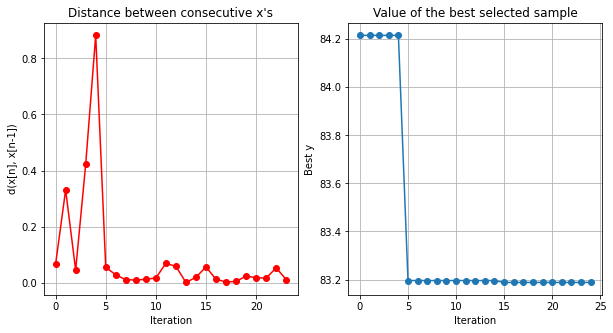

In [7]:
optimizer.plot_convergence()

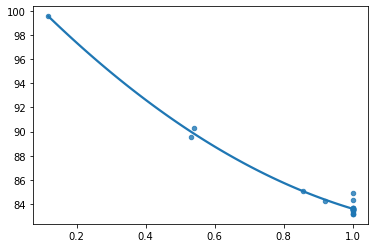

In [8]:
sns.regplot(x=list_C, y=list_score, order=2, ci=None, scatter_kws={"s": 20});

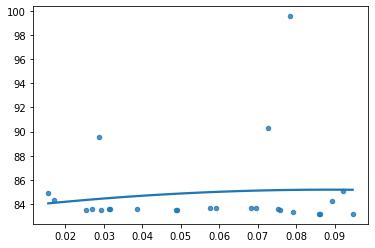

In [9]:
sns.regplot(x=list_gamma, y=list_score, order=2, ci=None, scatter_kws={"s": 20});